### Import Libraries

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


### Dataset preparation

In [74]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


train_ds = datasets.FashionMNIST(root='/dataset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_ds = datasets.FashionMNIST(root='/dataset', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=True)

In [75]:
train_images, train_labels = next(iter(trainloader))
test_images, test_labels = next(iter(testloader))
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 28, 28])
torch.Size([128])


In [76]:
train_images, train_labels = train_images.to(device), train_labels.to(device)
test_images, test_labels = test_images.to(device), test_labels.to(device)

### Define DNN model

In [77]:
class DNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.log_softmax(self.fc7(x), dim=1)
        return x

In [78]:
model = DNNClassifier()
print(model)

DNNClassifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=10, bias=True)
)


In [79]:
model.to(device)

DNNClassifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=10, bias=True)
)

### Model Training

In [80]:
creterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 20
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        loss = creterian(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Loss = {running_loss/len(trainloader)} in {epoch+1} epoch")

Loss = 0.6682646280285646 in 1 epoch
Loss = 0.4254917361334697 in 2 epoch
Loss = 0.383227425279902 in 3 epoch
Loss = 0.34962651886538404 in 4 epoch
Loss = 0.32750898555143554 in 5 epoch
Loss = 0.3141323319439695 in 6 epoch
Loss = 0.29973404379541685 in 7 epoch
Loss = 0.28369064711685626 in 8 epoch
Loss = 0.2745355394984613 in 9 epoch
Loss = 0.2672413529109345 in 10 epoch
Loss = 0.2601585351010121 in 11 epoch
Loss = 0.25309142371865984 in 12 epoch
Loss = 0.24083627174213243 in 13 epoch
Loss = 0.23208381100567674 in 14 epoch
Loss = 0.23357670860631125 in 15 epoch
Loss = 0.22415665483106173 in 16 epoch
Loss = 0.2160615053639483 in 17 epoch
Loss = 0.20825075904634208 in 18 epoch
Loss = 0.2042889945161368 in 19 epoch
Loss = 0.19993888559753198 in 20 epoch


### Model Evaluation

In [81]:
model = DNNClassifier()
creterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 20
step = 0
train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        y_pred = model(images)
        loss = creterian(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                y_pred = model(images)
                test_loss = creterian(y_pred, labels)
                
                ps = torch.exp(y_pred)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

Epoch: 1/20..  Training Loss: 0.693..  Test Loss: 0.005..  Test Accuracy: 0.812
Epoch: 2/20..  Training Loss: 0.436..  Test Loss: 0.003..  Test Accuracy: 0.840
Epoch: 3/20..  Training Loss: 0.374..  Test Loss: 0.008..  Test Accuracy: 0.856
Epoch: 4/20..  Training Loss: 0.347..  Test Loss: 0.007..  Test Accuracy: 0.848
Epoch: 5/20..  Training Loss: 0.326..  Test Loss: 0.006..  Test Accuracy: 0.866
Epoch: 6/20..  Training Loss: 0.308..  Test Loss: 0.007..  Test Accuracy: 0.861
Epoch: 7/20..  Training Loss: 0.297..  Test Loss: 0.006..  Test Accuracy: 0.869
Epoch: 8/20..  Training Loss: 0.284..  Test Loss: 0.005..  Test Accuracy: 0.877
Epoch: 9/20..  Training Loss: 0.275..  Test Loss: 0.001..  Test Accuracy: 0.876
Epoch: 10/20..  Training Loss: 0.270..  Test Loss: 0.012..  Test Accuracy: 0.882
Epoch: 11/20..  Training Loss: 0.258..  Test Loss: 0.001..  Test Accuracy: 0.883
Epoch: 12/20..  Training Loss: 0.248..  Test Loss: 0.003..  Test Accuracy: 0.877
Epoch: 13/20..  Training Loss: 0.239.

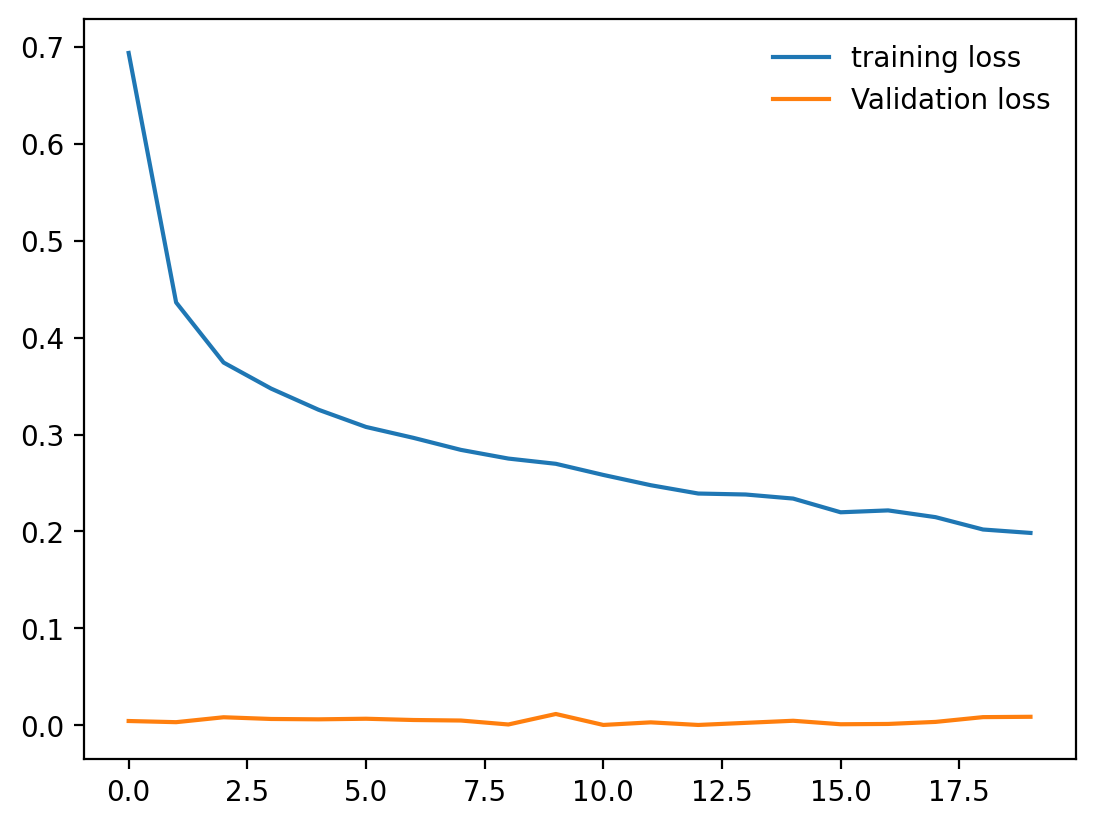

In [82]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Model Saving

In [83]:
torch.save(model.state_dict(), 'model_weights_Fashion.pth')

### With Dropout

In [84]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # 0.2정도를 무작위로 골라 dropout한다.
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output은 dropout하면 안된다..
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [86]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # 다시 트레이닝 과정으로 돌아간다.
        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/20..  Training Loss: 0.604..  Test Loss: 0.456..  Test Accuracy: 0.832
Epoch: 2/20..  Training Loss: 0.459..  Test Loss: 0.421..  Test Accuracy: 0.850
Epoch: 3/20..  Training Loss: 0.424..  Test Loss: 0.401..  Test Accuracy: 0.853
Epoch: 4/20..  Training Loss: 0.399..  Test Loss: 0.398..  Test Accuracy: 0.857
Epoch: 5/20..  Training Loss: 0.385..  Test Loss: 0.393..  Test Accuracy: 0.865
Epoch: 6/20..  Training Loss: 0.377..  Test Loss: 0.373..  Test Accuracy: 0.864
Epoch: 7/20..  Training Loss: 0.367..  Test Loss: 0.379..  Test Accuracy: 0.860
Epoch: 8/20..  Training Loss: 0.360..  Test Loss: 0.412..  Test Accuracy: 0.860
Epoch: 9/20..  Training Loss: 0.358..  Test Loss: 0.367..  Test Accuracy: 0.868
Epoch: 10/20..  Training Loss: 0.346..  Test Loss: 0.370..  Test Accuracy: 0.865
Epoch: 11/20..  Training Loss: 0.340..  Test Loss: 0.372..  Test Accuracy: 0.871
Epoch: 12/20..  Training Loss: 0.342..  Test Loss: 0.360..  Test Accuracy: 0.873
Epoch: 13/20..  Training Loss: 0.335.

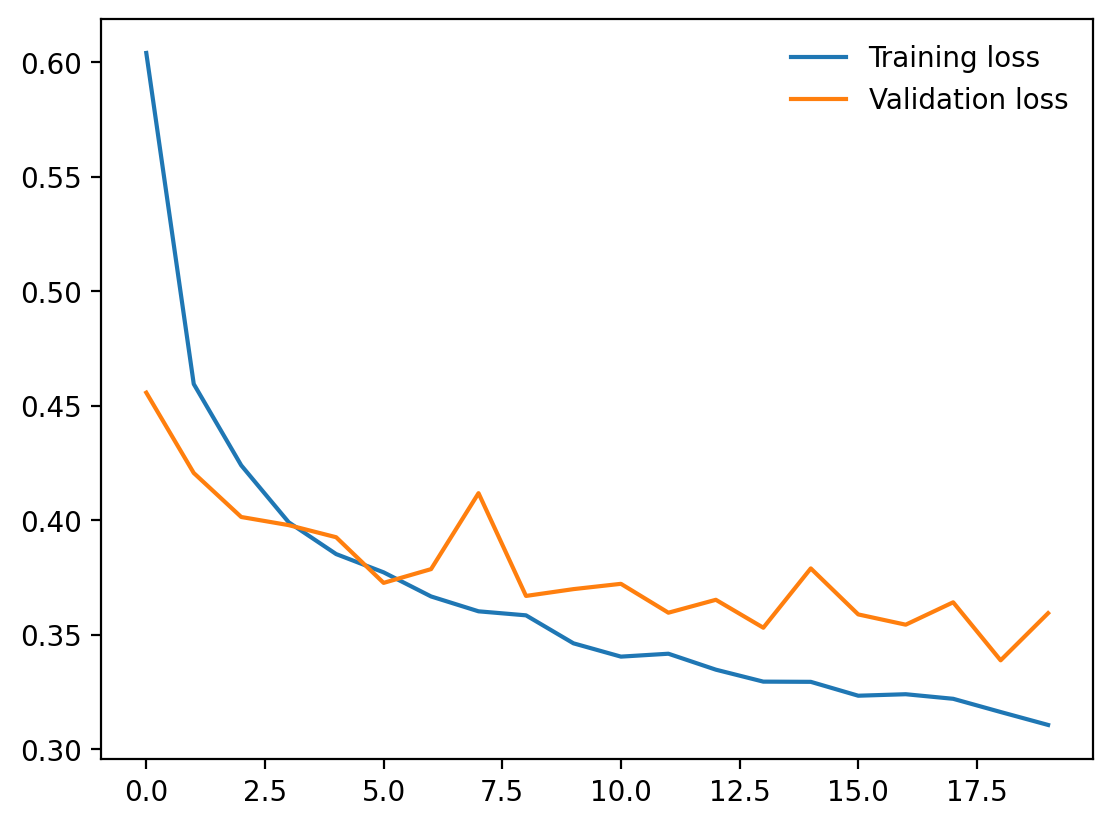

In [87]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### VIsualization on Tensorboard